In [156]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [157]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [158]:
hf.keys()

<KeysViewHDF5 ['data']>

In [159]:
data = np.array(hf.get('data'))

In [160]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [161]:
hf.close()

## Problem 1

How the solar phase varies with time:

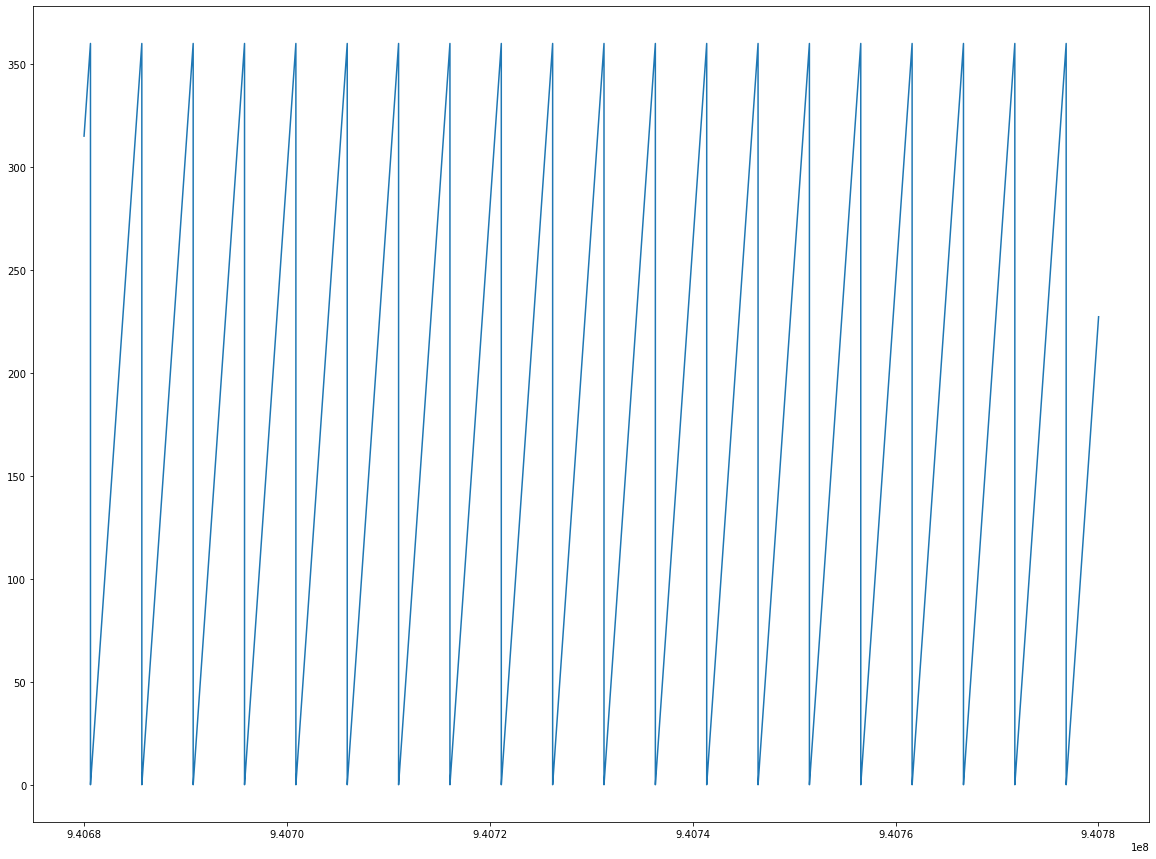

In [163]:
x = data[0, 0:1000000]
y = data[1, 0:1000000]
plt.plot(x, y)
plt.show()

How the longitude varies with time:

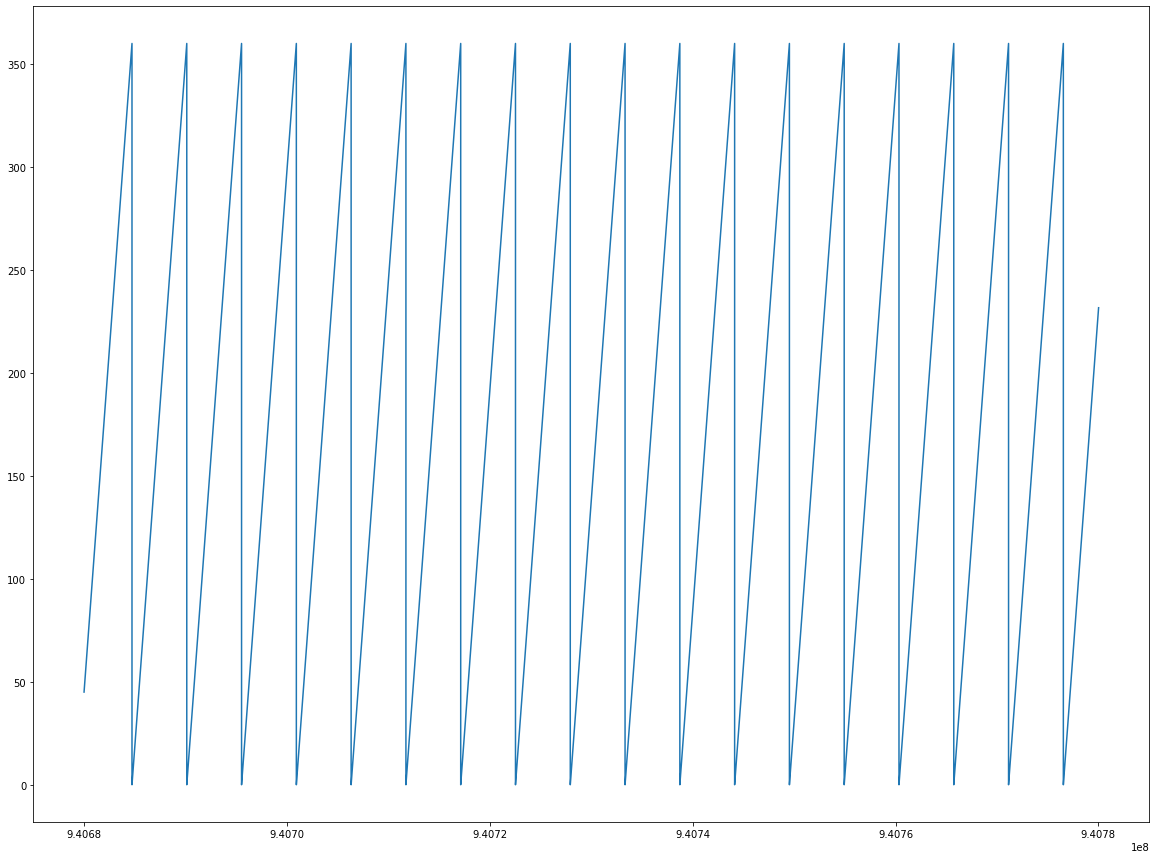

In [74]:
x = data[0, 0:1000000]
y = data[2, 0:1000000]
plt.plot(x, y)
plt.show()

How the particle count varies with time:

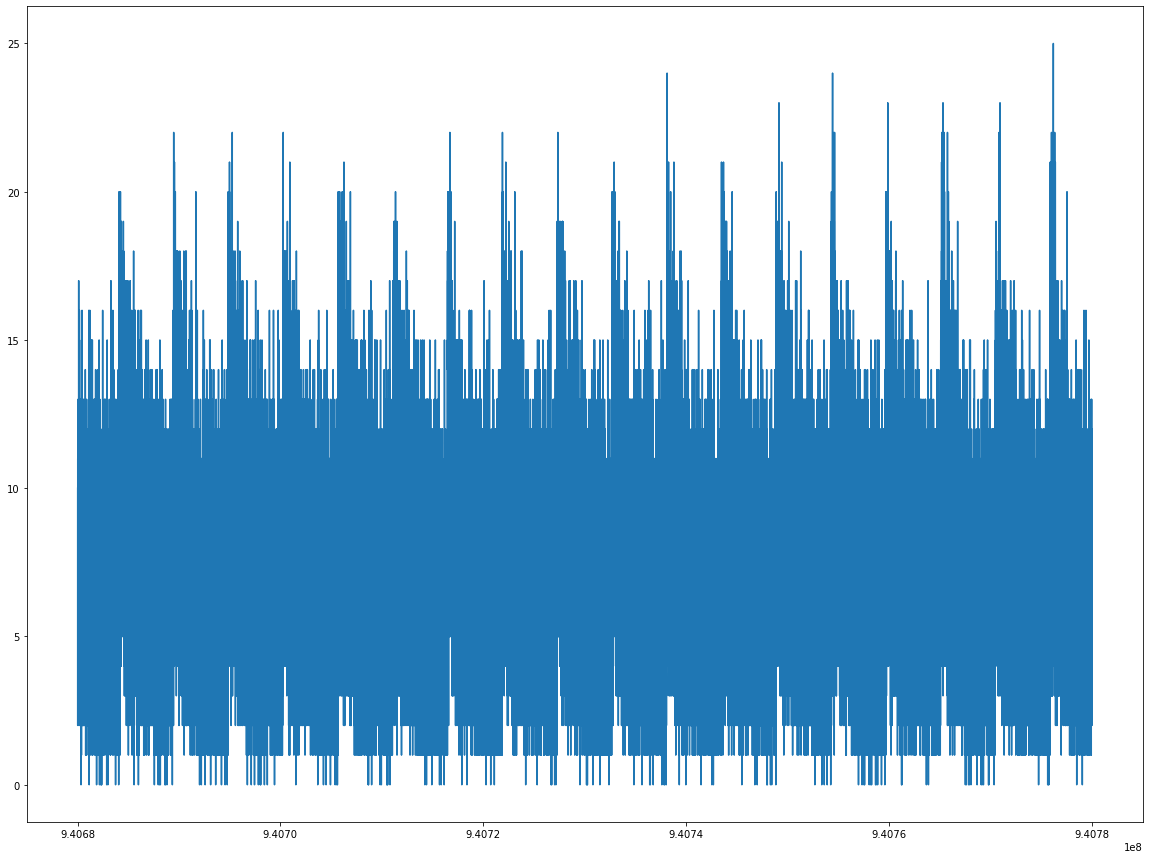

In [164]:
x = data[0, 0:1000000:10]
y = data[3, 0:1000000:10]
plt.plot(x, y)
plt.show()

We can see from the plot of particle count versus time that the background is not consistent across the dataset. The mean particle count of the background seems to increase and decrease periodically.

Seeing how the particle count varies with solar phase and longitude:

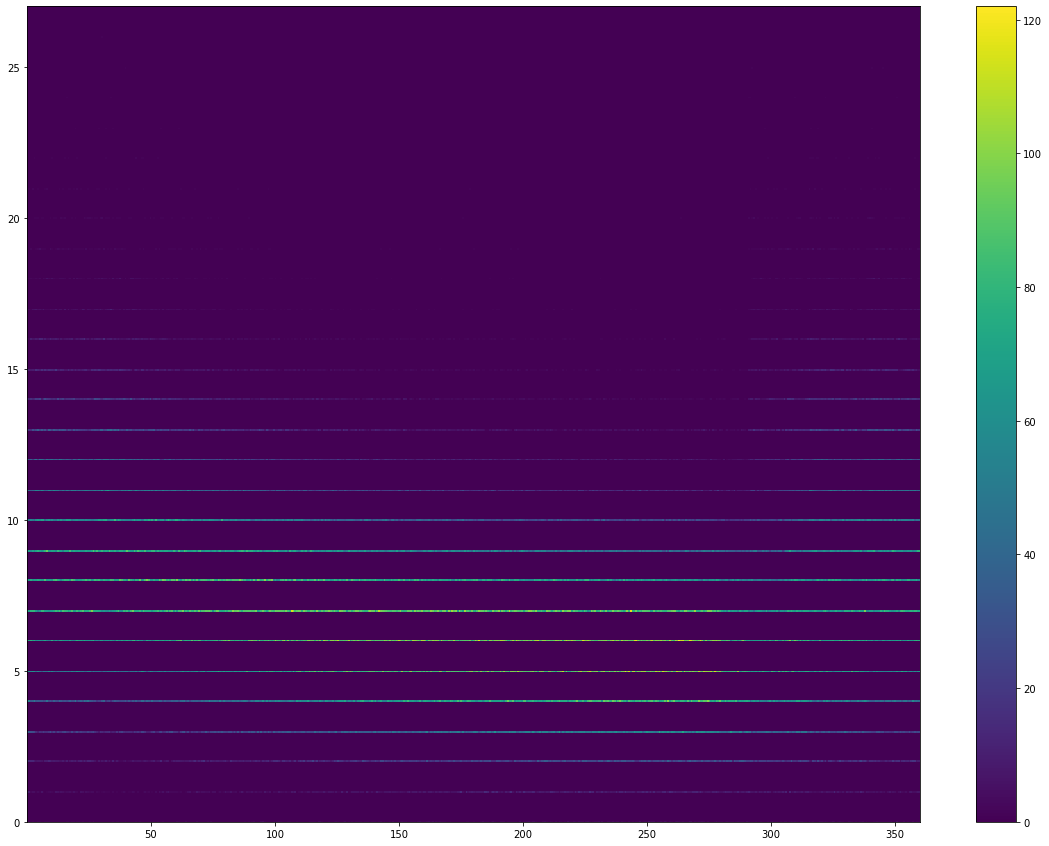

In [53]:
x = data[1, 100000:400000]
y = data[3, 100000:400000]
plt.hist2d(x, y, 500)
plt.colorbar()
plt.show()

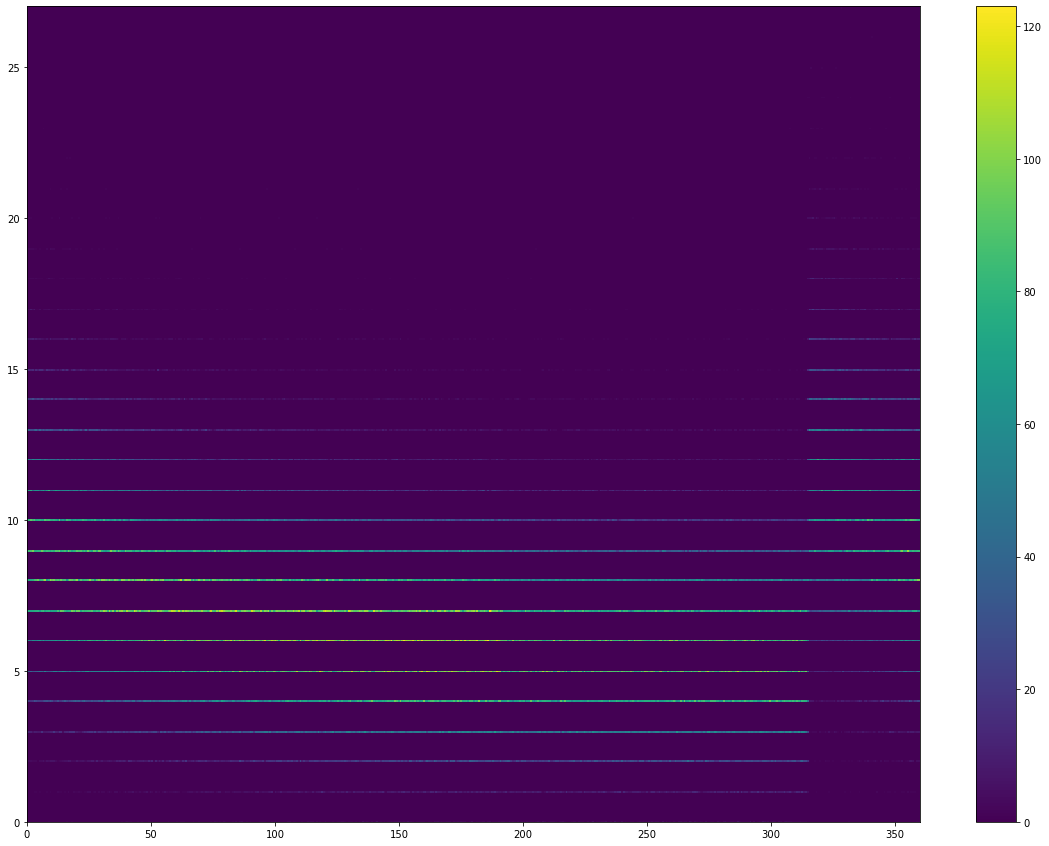

In [62]:
x = data[2, 100000:400000]
y = data[3, 100000:400000]
plt.hist2d(x, y, 500)
plt.colorbar()
plt.show()

We can see that the mean particle count makes a jump from around 6 to around 9 somewhere between 300 and 350 degrees longitude.

The background is a Poisson distribution, so I can create a Poisson distribution with a mean that varies according to how the mean of our background varies with longitude to more accurately describe the background.

In order to see how the distribution changes with respect to the longitude, I take the mean of the particle count at each value of the longitude. Then I plot the means versus longitude:

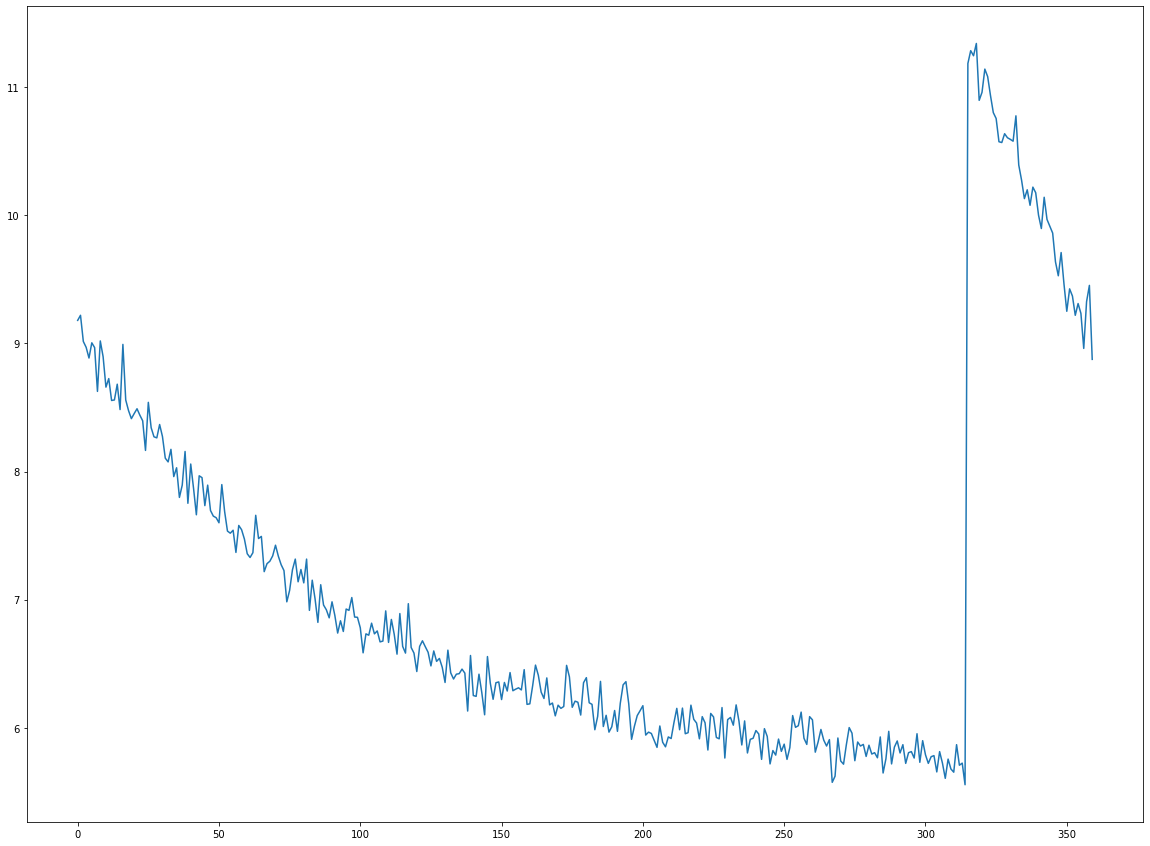

In [179]:
counts = data[3]
longs = np.arange(360)
means = []
for i in longs:
    mean = np.mean(counts[data[2]==i])
    means.append(mean)
plt.plot(longs, means)
plt.show()

In [111]:
print('Mean at longitude of 314 degrees: ' + str(means[314]))
print('Mean at longitude of 315 degrees: ' + str(means[315]))

Mean at longitude of 314 degrees: 5.55625
Mean at longitude of 315 degrees: 11.183333333333334


So there is a big jump in the mean from 5.6 particles to 11.2 particles in between 314 and 315 degrees.

So we want to create a time-dependent Poisson for our background that reflects this change in the mean:

My time dependent background distribution is a Poisson distribution with a mean equal to the mean particle count at the longitude of the time being examined.

In [239]:
def model(time):
    for i in range(len(data[0])):
        if data[0, i] == time:
            long = data[2, i]
            print('Longitude: ' + str(long))
    mean = means[int(long)]
    print('Mean: ' + str(mean))
    x = np.arange(0,20)
    plt.vlines(x, 0, stats.poisson.pmf(x, mean), colors='b', lw=54, alpha=0.5)
    plt.title('Piosson Distribution')
    plt.xlabel('x (number of events)')
    plt.xlim(0, 20)
    plt.ylabel('Probability')
    plt.show()

Comparing my model to the real data:

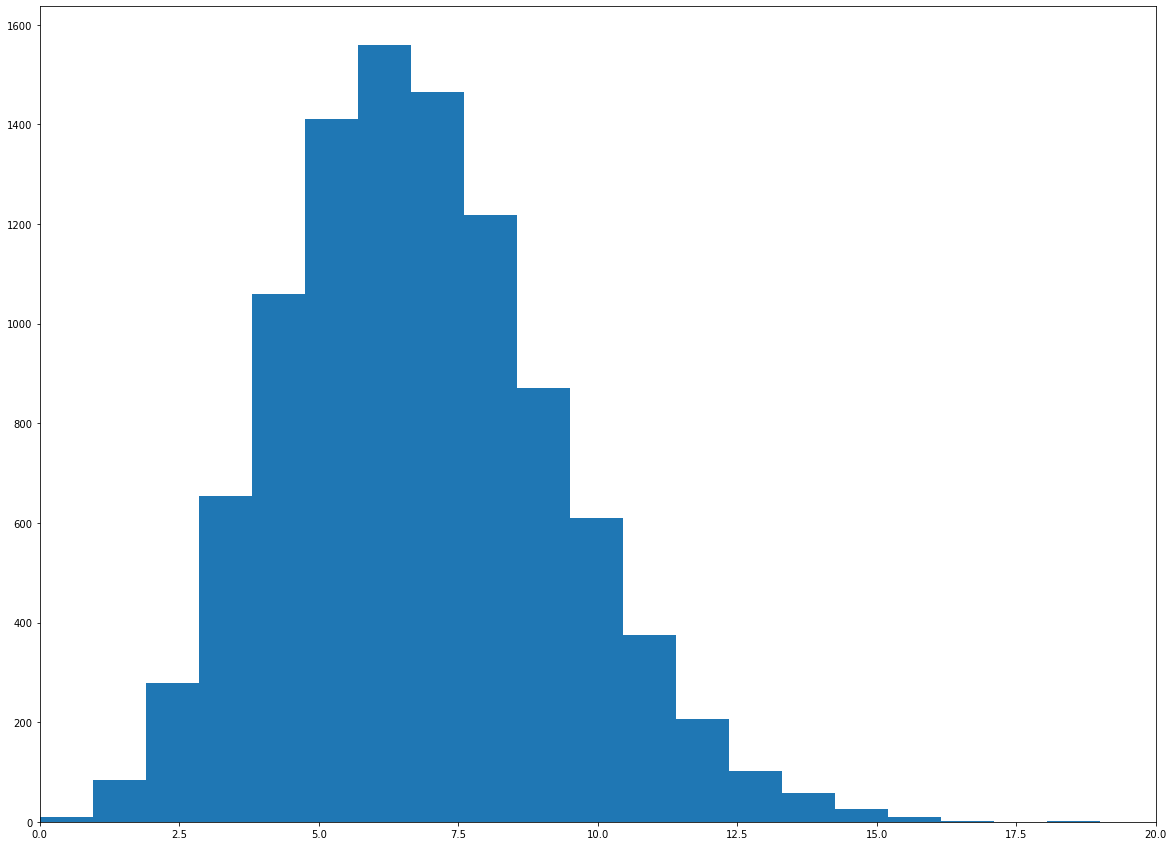

In [220]:
y = data[3,60000:70000]
plt.hist(y, 20)
plt.xlim(0, 20)
plt.show()

Longitude: 118.33333333333331
Mean: 6.627083333333333


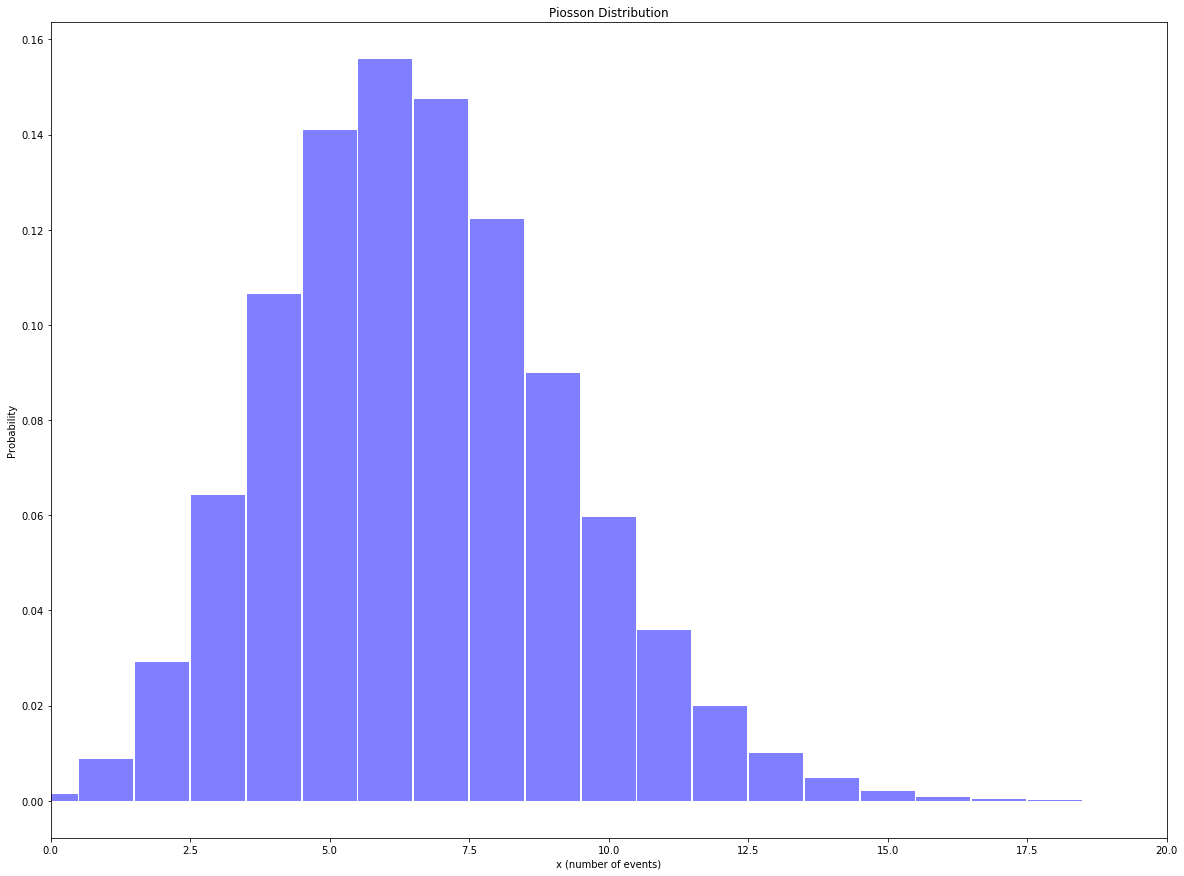

In [241]:
model(data[0,65000])

It seems like the model very closely approximates the real data.

## Problem 2

In [154]:
hf = h5py.File('images.h5', 'r')

OSError: Unable to open file (file signature not found)

In [148]:
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [149]:
data = np.array(hf.get('data'))

In [152]:
data

array(None, dtype=object)

In [ ]:
https://canvas.uw.edu/courses/1401649/files/67789336/download?wrap=1